# Check that fits work in all four quadrants
We had a bug report from Vanessa that it did not work in the third and fourth quadrants

## Imports

We need to explictly add the path to the library since we haven't installed it yet.

In [1]:
import time

In [2]:
start_time = time.time()
from pathlib import Path

In [3]:
import confitti
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns

Check that we have the right module

In [4]:
confitti?

## Where to save the figures

In [5]:
figpath = Path.cwd().parent / "figs"
saveprefix = "demo05"

## Test data

I use the same pattern of 7 points as the basis, but we are going to rotate it through different angles to make sure that the fits still work

In [6]:
xpts0, ypts0 = np.array([1, 2, 3, 4, 5, 6, 7]), np.array([0, 4, 6, 7, 6, 4, 0])
ypts0 += xpts0
xpts0 *= 3

## Function to rotate the points

Rotate anticlockwise through an angle theta in degrees

In [7]:
def rotate(x, y, theta):
    c = np.cos(np.deg2rad(theta))
    s = np.sin(np.deg2rad(theta))
    xx = x * c - y * s
    yy = x * s + y * c
    return xx, yy

In [8]:
rotate(1, 1, -90)

(1.0, -0.9999999999999999)

Plot the points for 6 different orientations

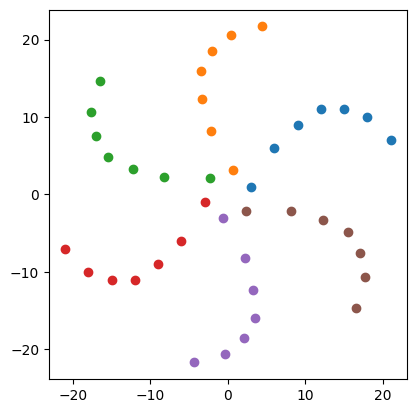

In [9]:
fig, ax = plt.subplots()
for theta in np.arange(6) * 60:
    xpts, ypts = rotate(xpts0, ypts0, theta)
    ax.scatter(xpts, ypts)
ax.set_aspect("equal")
...;

In [10]:
fig.savefig(figpath / f"{saveprefix}-points.pdf", bbox_inches="tight")

## Initial guess at conic parameters

This is done automatically inside the fitting function, but we will do it explicitly so we can see what it is doing

I have added some debug print statements inside of `init_conic_from_xy()` so we can see what is going on. This led to the realization that the problem was with the use of the median for finding the initia focus position. I have switched it to the mean, which seems to have solved the problem.

In [11]:
theta = 210
xpts, ypts = rotate(xpts0, ypts0, theta)
confitti.DEBUG = True
initial_conic = confitti.init_conic_from_xy(xpts, ypts)
initial_conic

{'x0': -6.4637334168418334,
 'y0': -12.804485315449162,
 'r0': 4.670003423475774,
 'theta0': 306.9268304461369,
 'eccentricity': 1.0}

Look at the residuals for this initial guess, which is
$$
r - e d
$$
where $r$ is the radius of each point from the focus and $d$ is the distance of each point from the directrix.

We turn on DEBUG so that the residual function will print out the individual vectors, $r$, $d$, and $e \times d$.

In [12]:
initial_params = lmfit.create_params(**initial_conic)
confitti.residual(initial_params, xpts, ypts)

array([-3.74707344, -4.17914182, -4.6333713 , -3.07723235, -2.23706426,
       -1.56522843, -2.23558463])

The residuals are all negative, meaning points are inside the conic. This suggests that `r0` is overestimated.

Turn the `DEBUG` flag back off.

In [13]:
confitti.DEBUG = False

In [14]:
init_xy = confitti.XYconic(**initial_conic)
print(init_xy)

Conic section curve with focus at (-6.4637334168418334, -12.804485315449162), scale factor 4.670003423475774, angle 306.9268304461369, and eccentricity 1.0.


/Users/will/Dropbox/confitti/src/confitti/confitti.py:143: RuntimeWarning: divide by zero encountered in divide
  self.r0


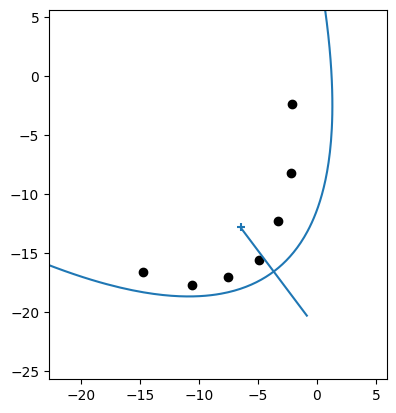

In [15]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts, color="k")

c = "C0"
ax.plot(init_xy.x_pts, init_xy.y_pts, color=c)
ax.scatter(init_xy.x0, init_xy.y0, marker="+", color=c)
ax.plot([init_xy.x0, init_xy.x_mirror], [init_xy.y0, init_xy.y_mirror], color=c)

ax.set_aspect("equal")
margin = 8
ax.set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

## Do the fitting for a range of rotations of the origina data

We make a dictionary with keys of the rotation angles that holds the data points and the two fits (parabola and general conic)

In [16]:
results = {}
for theta in (-3.0 + np.arange(12) * 30):
    xpts, ypts = rotate(xpts0, ypts0, theta)
    result_p = confitti.fit_conic_to_xy(xpts, ypts, allow_negative_theta=True, only_parabola=True)
    result_e = confitti.fit_conic_to_xy(xpts, ypts, allow_negative_theta=True, only_parabola=False)
    results[theta] = {
        "x": xpts,
        "y": ypts,
        "pfit": result_p,
        "efit": result_e,
    }

Note that the argument `allow_negative_theta` is true by default. It is recommended that this option should always be left turned on. It is just included here for testing purposes. If it is set to false, then one of the fits fails because the angle gets trapped at 0.0. 


Look at the residuals:

In [17]:
[result["efit"].residual for result in results.values()]

[array([ 0.01612976,  0.03542973, -0.17974087,  0.25920834, -0.22631144,
         0.12003414, -0.02474966]),
 array([ 0.01613172,  0.03542652, -0.17974225,  0.25921107, -0.22630917,
         0.12003125, -0.02474913]),
 array([ 0.01613019,  0.03543041, -0.17974226,  0.2592065 , -0.22631043,
         0.12003725, -0.02475166]),
 array([ 0.01612941,  0.03543037, -0.17974067,  0.25920775, -0.22631182,
         0.12003482, -0.02474985]),
 array([ 0.01612895,  0.03543025, -0.17973967,  0.25920863, -0.22631267,
         0.12003316, -0.02474865]),
 array([ 0.01612905,  0.03543068, -0.1797402 ,  0.25920773, -0.22631235,
         0.12003461, -0.02474952]),
 array([ 0.01612924,  0.03543187, -0.17974153,  0.25920534, -0.22631156,
         0.12003841, -0.02475178]),
 array([ 0.01612728,  0.03543509, -0.17974015,  0.25920261, -0.22631382,
         0.1200413 , -0.02475231]),
 array([ 0.01612882,  0.03543119, -0.17974014,  0.25920718, -0.22631256,
         0.1200353 , -0.02474978]),
 array([ 0.01612959

Those all look the same, which is good.

Extract all the parameters as a dataframe

In [18]:
import pandas as pd

In [19]:
df = pd.DataFrame(
    {"angle": angle, **result["efit"].params.valuesdict()}
    for angle, result in results.items()
)
df.style.format(precision=3)

,angle,x0,y0,r0,theta0,eccentricity
0,-3.000,14.580,7.191,3.242,84.803,0.934
1,27.000,9.031,13.518,3.242,114.803,0.934
2,57.000,1.062,16.222,3.242,144.803,0.934
3,87.000,-7.191,14.580,3.242,174.803,0.934
4,117.000,-13.518,9.031,3.242,204.803,0.934
5,147.000,-16.222,1.062,3.242,234.803,0.934
6,177.000,-14.580,-7.191,3.242,264.803,0.934
7,207.000,-9.031,-13.518,3.242,294.803,0.934
8,237.000,-1.062,-16.222,3.242,324.803,0.934
9,267.000,7.191,-14.580,3.242,-5.197,0.934


Now look at the fitted angle minus the data rotation angle

[(0.0, 180.0)]

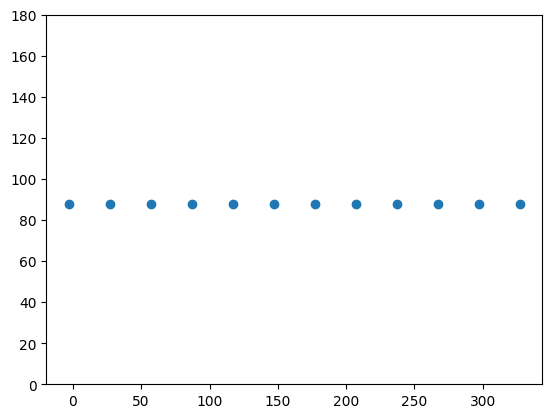

In [20]:
fig, ax = plt.subplots()
ax.scatter(df["angle"], (df["theta0"] - df["angle"]) % 360)
ax.set(ylim=[0, 180])

This is constant, which is what we hoped. This show that the fit is the same for all the different data rotation angle.

## Plotting the best fit onto the data

In [21]:
bestp_xy = confitti.XYconic(**result_p.params.valuesdict())
print(bestp_xy)

Conic section curve with focus at (16.190734319538716, -0.7008957053525796), scale factor 2.9827096730961924, angle 57.1860409266414, and eccentricity 1.0.


/Users/will/Dropbox/confitti/src/confitti/confitti.py:143: RuntimeWarning: divide by zero encountered in divide
  self.r0


In [22]:
beste_xy = confitti.XYconic(**result_e.params.valuesdict())
print(beste_xy)

Conic section curve with focus at (16.222207097352538, -1.0623410493666496), scale factor 3.2421921478688223, angle 54.80272929721136, and eccentricity 0.9336278052207372.


In [23]:
init_xy = confitti.XYconic(**initial_conic)
print(init_xy)

Conic section curve with focus at (-6.4637334168418334, -12.804485315449162), scale factor 4.670003423475774, angle 306.9268304461369, and eccentricity 1.0.


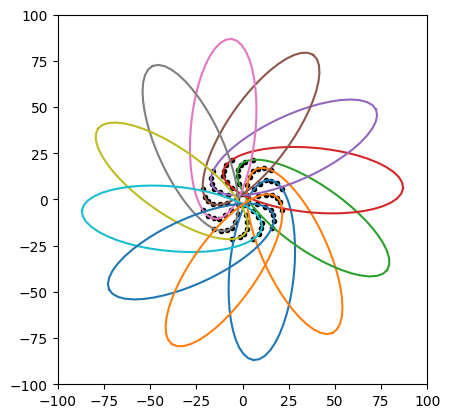

In [24]:
fig, ax = plt.subplots()
for theta, result in results.items():
    beste_xy = confitti.XYconic(**result["efit"].params.valuesdict())
    ax.plot(beste_xy.x_pts, beste_xy.y_pts)
    ax.scatter(result["x"], result["y"], marker=".", color="k")
ax.set_aspect("equal")
_limit = 100
ax.set(xlim=[-_limit, _limit], ylim=[-_limit, _limit])
...;

In [25]:
fig.savefig(figpath / f"{saveprefix}-best-fits.pdf", bbox_inches="tight")

## Execution time for notebook

In [26]:
print(f"--- {time.time() - start_time} seconds ---")

--- 14.342547178268433 seconds ---
